## First average out the 10 runs to eliminate sampling effects

In [1]:
import pickle
from collections import defaultdict
from framework.losses import interpoint_distance
import os
import pandas as pd

In [2]:
RESULTS_DIR = "./results/exp2"
N_RESULT_FILES = 10

def _load(name):
    with open(name, "rb") as f:
        return pickle.load(f)

In [3]:
df  = pd.DataFrame(_load('./results/exp2/experimenttwo_1.pkl'))
df

,size,sampling,dataset,algorithm,emb_x,labels,loss,convergence
0,0.3,random,mnist,umap,"[[7.921793, 2.5790558], [6.475509, 11.340623],...","[3, 5, 5, 6, 5, 9, 4, 3, 6, 7, 0, 7, 6, 9, 8, ...",0,none
1,0.3,random,mnist,tsne,"[[-20.37348484834048, 4.4525549489057905], [4....","[6, 1, 8, 7, 7, 2, 4, 1, 0, 9, 4, 8, 8, 2, 4, ...",0,none
2,0.3,random,fmnist,umap,"[[9.920636, -0.025556076], [-0.5274171, 10.179...","[6, 6, 1, 7, 9, 4, 0, 0, 2, 7, 8, 2, 9, 7, 0, ...",0,none
3,0.3,random,fmnist,tsne,"[[34.30523100924179, 7.83921125937937], [-56.9...","[8, 3, 9, 2, 3, 8, 4, 1, 2, 7, 6, 2, 4, 3, 8, ...",0,none
4,0.3,random,olivetti,umap,"[[0.6772406, 0.23185569], [1.1478063, -2.03689...","[13, 9, 18, 30, 12, 12, 2, 2, 8, 5, 39, 8, 15,...",0,none
...,...,...,...,...,...,...,...,...
91,1.0,stratified,mnist,tsne,"[[-0.9206149735596656, -28.836905745440987], [...","[8, 7, 1, 4, 6, 2, 8, 7, 5, 9, 0, 3, 9, 6, 6, ...",0,none
92,1.0,stratified,fmnist,umap,"[[10.587783, -2.223641], [0.57654274, 11.36299...","[2, 8, 7, 1, 4, 9, 4, 5, 3, 3, 2, 7, 6, 2, 9, ...",0,none
93,1.0,stratified,fmnist,tsne,"[[38.013554210453265, 8.72118307231902], [-48....","[2, 8, 7, 1, 4, 9, 4, 5, 3, 3, 2, 7, 6, 2, 9, ...",0,none
94,1.0,stratified,olivetti,umap,"[[5.431146, 9.569511], [4.278046, 7.1523075], ...","[15, 10, 1, 34, 2, 17, 35, 33, 16, 24, 31, 14,...",0,none


In [7]:
RESULTS_DIR = "./results/exp2"
N_RESULT_FILES = 10
for filename in os.listdir(RESULTS_DIR):
    print(filename)
    
if len(os.listdir(RESULTS_DIR)) != N_RESULT_FILES:
    print("Some runs are missing please check the results folder")

experimenttwo_5.pkl
experimenttwo_4.pkl
experimenttwo_6.pkl
experimenttwo_7.pkl
experimenttwo_3.pkl
experimenttwo_2.pkl
experimenttwo_1.pkl
experimenttwo_10.pkl
experimenttwo_9.pkl
experimenttwo_8.pkl


In [11]:
def group(results):
    
    def _sort(groups):
        
        sorted_groups = {}
        for key, x in groups.items():
            sorted_groups[key] = sorted(x, key=lambda k: k['size'])
            
        return sorted_groups
    
    groups = defaultdict(list)
    for result in results:
        samp, dataset, algo = result['sampling'], result['dataset'], result['algorithm']
        key = tuple([samp, dataset, algo])
        groups[key].append({
            "emb_x": result['emb_x'],
            "labels": result['labels'],
            "size": result['size']
        })
    return _sort(dict(groups))

In [12]:
def groups_to_interpoint(groups):
    
    def _do_interpoint(arr):
        embeddings = [x['emb_x'] for x in arr]
        interpoints = []
        for i in range(0, len(embeddings) - 1):
            
            #Set j = -1 to look at distance from the ground truth. Set j = i-1 to look at incremental difference.
            j = -1
            
            interpoints.append(interpoint_distance(embeddings[i], embeddings[j]))
        return interpoints
        
    interpoint_groups = {}
    for key, value in groups.items():
        interpoint_groups[key] = _do_interpoint(value)

    return interpoint_groups

In [13]:
def create_average_data(RESULTS_DIR, N_RESULT_FILES, preprocess="interpoint"):
    print("Listing all result files...")
    for filename in os.listdir(RESULTS_DIR):
        print(filename)
    
    if len(os.listdir(RESULTS_DIR)) != N_RESULT_FILES:
        print("Some runs are missing please check the results folder")
    
    print("---------------------------------------------------------")
    
    print("Combining files now....")
    exp1_runs = {}
    i=0
    print("Loading Data...")
    for run in os.listdir(RESULTS_DIR):
        result = _load(os.path.join(RESULTS_DIR, run))
        if preprocess == "interpoint":
            result = groups_to_interpoint(group(result))
        exp1_runs[i] = pd.DataFrame(result)
        i +=1
    
    print("Averaging...")
    averages = exp1_runs[0].copy()
    averages.loc[:,:] = 0
    for i in range(N_RESULT_FILES):
        for j in range(len(averages.columns)):
            averages.iloc[:,j] += exp1_runs[i].iloc[:,j]
    
    averages = averages / N_RESULT_FILES
    
    print("Merge complete!")
    
    return averages





In [9]:
interpoint_results = create_average_data(RESULTS_DIR, N_RESULT_FILES)

Listing all result files...
experimenttwo_5.pkl
experimenttwo_4.pkl
experimenttwo_6.pkl
experimenttwo_7.pkl
experimenttwo_3.pkl
experimenttwo_2.pkl
experimenttwo_1.pkl
experimenttwo_10.pkl
experimenttwo_9.pkl
experimenttwo_8.pkl
---------------------------------------------------------
Combining files now....
Loading Data...
Averaging...
Merge complete!


In [10]:
interpoint_results

random                                                           \
         mnist                       fmnist                    olivetti   
          umap          tsne           umap           tsne         umap   
0  4286.266804  17313.704105   29157.305930  295749.969680  1297.647726   
1  4975.356547  13861.103410   29966.587516  132616.498590   868.026939   
2  5444.337061   8089.769120  285394.317607  206281.372933   719.098059   
3  4679.124752   8939.404775  295014.831334  211414.228350   588.513526   
4  3602.810984   4196.135656   19818.506407  173467.649394   549.630544   
5  2850.486806   5723.629614   17042.717163   94482.016139   441.066015   
6  5803.671268   3112.870701   13021.632742   83929.407552   896.225264   

                 stratified                                              \
                      mnist                       fmnist                  
          tsne         umap          tsne           umap           tsne   
0  1590.988821  5025.214247  17413.500934   24760.439234  256319.636682   
1  1041.019089  2917.498450   8112.491274   12184.945195  170680.248466   
2  1263.460334  4328.249879  11389.566151  288302.500224  201063.195359   
3  1123.000818  6504.456378   4091.233645  295034.122645  138999.333755   
4  1136.113017  1641.451144   6655.260167   14639.933194  125072.240403   
5  1941.558104  5310.916994   6985.616093   13202.486257   92070.298021   
6  1861.548420  5386.572168   4951.836504   13229.846307   97985.239284   

                             
      olivetti               
          umap         tsne  
0  1028.197554  1878.301385  
1   703.865512  1044.792399  
2   588.486175   613.800788  
3   858.787398  1505.931653  
4   398.147342  1816.836154  
5   594.019406  1933.006684  
6   397.466931  1682.337897

In [20]:
interpoint_results.to_csv('exp2_interpoint_results.csv')

In [14]:
distance_from_truth_results = create_average_data(RESULTS_DIR, N_RESULT_FILES)

Listing all result files...
experimenttwo_5.pkl
experimenttwo_4.pkl
experimenttwo_6.pkl
experimenttwo_7.pkl
experimenttwo_3.pkl
experimenttwo_2.pkl
experimenttwo_1.pkl
experimenttwo_10.pkl
experimenttwo_9.pkl
experimenttwo_8.pkl
---------------------------------------------------------
Combining files now....
Loading Data...
Averaging...
Merge complete!


In [15]:
distance_from_truth_results

random                                                           \
         mnist                       fmnist                    olivetti   
          umap          tsne           umap           tsne         umap   
0  4286.266804  17313.704105   29157.305930  295749.969680  1297.647726   
1  6969.666251  10914.570623   29986.304794  276434.178333   943.997218   
2  4901.424914  10101.429936  302925.098500  177630.472147   383.362385   
3  2202.620551   7689.037609   16913.258996  184377.281795   872.324785   
4  2704.840795   6465.311703   20467.219723  106959.679890   781.326575   
5  1683.323694   3295.809779   11754.671718   78060.490141  1018.801775   
6  6111.825807   2095.816402   12674.189618   65441.996220   630.984333   

                 stratified                                              \
                      mnist                       fmnist                  
          tsne         umap          tsne           umap           tsne   
0  1590.988821  5025.214247  17413.500934   24760.439234  256319.636682   
1  1107.201207  3849.977586  14315.500111   20893.011414  260255.958702   
2  1691.092438  4770.213570   7017.586237  301689.363259  166131.415526   
3  1932.515698  8142.251616   6223.452071   16134.578617  125575.362080   
4  1363.837441  7815.016163   8772.454826   13861.879120   98356.336433   
5  2036.682544  4871.869817   5259.984439   11907.221310   89815.329848   
6  1612.710191  8605.105275   1595.323476    8372.467063   71480.879455   

                             
      olivetti               
          umap         tsne  
0  1028.197554  1878.301385  
1   419.039223  1421.233265  
2   853.278211  1417.213569  
3   295.997851  1933.731717  
4   508.753106  1529.093741  
5   687.724916  1547.613695  
6   376.766000   942.608147

In [21]:
distance_from_truth_results.to_csv('exp2_distance_from_truth_results.csv')

### Now we look at plots!

In [102]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
SAMPLING = ['random', 'stratified']
ALGORITHMS = ['tsne', 'umap']
DATASETS = ['olivetti', 'fmnist', 'mnist']
x_axis = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

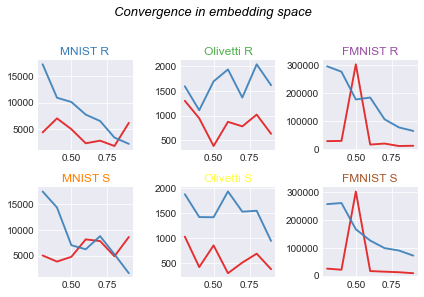

<Figure size 1080x720 with 0 Axes>

In [112]:
# Creating Tile plots
data = distance_from_truth_results
df = pd.DataFrame({
    'x': x_axis,
    'umap (r1)': data['random']['mnist']['umap'],
    'tsne (r1)': data['random']['mnist']['tsne'],
    'umap (r2)': data['random']['olivetti']['umap'],
    'tsne (r2)': data['random']['olivetti']['tsne'], 
    'umap (r3)': data['random']['fmnist']['umap'],
    'tsne (r3)': data['random']['fmnist']['tsne'], 
    'umap (s1)': data['stratified']['mnist']['umap'],
    'tsne (s1)': data['stratified']['mnist']['tsne'], 
    'umap (s2)': data['stratified']['olivetti']['umap'],
    'tsne (s2)': data['stratified']['olivetti']['tsne'], 
    'umap (s3)': data['stratified']['fmnist']['umap'],
    'tsne (s3)': data['stratified']['fmnist']['tsne'], 
    })

title = ["", "MNIST R ", "Olivetti R", "FMNIST R", 
         "MNIST S", "Olivetti S", "FMNIST S"]

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
col=0
skip = False
for column in range(1, len(df.columns)):
    if skip:
        skip = False
        continue
    num+=1
    # Find the right spot on the plot
    plt.subplot(2,3, num)
    plt.plot(df['x'], df.iloc[:,[column]], marker='', color=palette(col), linewidth=1.9, alpha=0.9, label=column)
    plt.plot(df['x'], df.iloc[:,[column+1]], marker='', color=palette(col+1), linewidth=1.9, alpha=0.9, label=column)
    
    # Add title
    plt.tick_params(labelbottom='off')
    plt.title(title[num], loc='center', fontsize=12, fontweight=0, color=palette(num))
    #plt.figure(figsize=(5,5))
    skip = True
    
# general title
plt.suptitle("Convergence in embedding space", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.tight_layout()
plt.figure(figsize=(15,10)) 

plt.savefig('fig1.jpg')

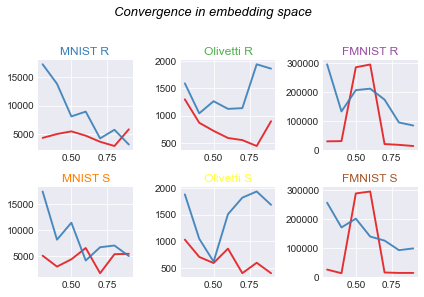

<Figure size 1080x720 with 0 Axes>

In [113]:
# Creating Tile plots
data = interpoint_results
df = pd.DataFrame({
    'x': x_axis,
    'umap (r1)': data['random']['mnist']['umap'],
    'tsne (r1)': data['random']['mnist']['tsne'],
    'umap (r2)': data['random']['olivetti']['umap'],
    'tsne (r2)': data['random']['olivetti']['tsne'], 
    'umap (r3)': data['random']['fmnist']['umap'],
    'tsne (r3)': data['random']['fmnist']['tsne'], 
    'umap (s1)': data['stratified']['mnist']['umap'],
    'tsne (s1)': data['stratified']['mnist']['tsne'], 
    'umap (s2)': data['stratified']['olivetti']['umap'],
    'tsne (s2)': data['stratified']['olivetti']['tsne'], 
    'umap (s3)': data['stratified']['fmnist']['umap'],
    'tsne (s3)': data['stratified']['fmnist']['tsne'], 
    })

title = ["", "MNIST R ", "Olivetti R", "FMNIST R", 
         "MNIST S", "Olivetti S", "FMNIST S"]

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
col=0
skip = False
for column in range(1, len(df.columns)):
    if skip:
        skip = False
        continue
    num+=1
    # Find the right spot on the plot
    plt.subplot(2,3, num)
    plt.plot(df['x'], df.iloc[:,[column]], marker='', color=palette(col), linewidth=1.9, alpha=0.9, label=column)
    plt.plot(df['x'], df.iloc[:,[column+1]], marker='', color=palette(col+1), linewidth=1.9, alpha=0.9, label=column)
    
    # Add title
    plt.tick_params(labelbottom='off')
    plt.title(title[num], loc='center', fontsize=12, fontweight=0, color=palette(num))
    #plt.figure(figsize=(5,5))
    skip = True
    
# general title
plt.suptitle("Convergence in embedding space", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.tight_layout()
plt.figure(figsize=(15,10)) 

plt.savefig('fig2.jpg')

In [38]:
def create_lineplots_by_dataset(data, dataset="mnist", sampling="random", metric="marginal"):
    if sampling == 'both':
        sns.lineplot(x_axis, data['random'][dataset]['umap'])
        sns.lineplot(x_axis, data['stratified'][dataset]['umap'])
        sns.lineplot(x_axis, data['random'][dataset]['tsne'])
        sns.lineplot(x_axis, data['stratified'][dataset]['tsne'])
        plt.legend(['umap(r)', 'umap(s)','tsne(r)', 'tsne(s)'])
        plt.title(str(dataset))


    else:
        sns.lineplot(x_axis, data[sampling][dataset]['umap'])
        sns.lineplot(x_axis, data[sampling][dataset]['tsne'])
        plt.legend(['umap', 'tsne'])
        plt.title(str(dataset) + " Interpoint Dist (" + str(sampling) + " sampling)")

    if metric == 'marginal':
        ylabel = 'Net change after 10% data increase'
    elif metric == "truth_dist":
        ylabel = "Dist from final position of point"
    
    plt.ylabel(ylabel)
    plt.xlabel('Dataset fraction')


/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


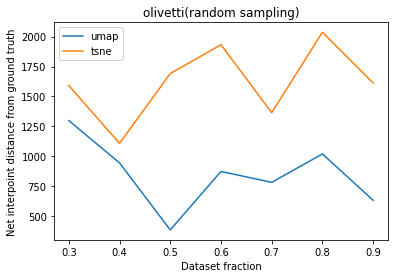

In [32]:
create_lineplots_by_dataset(data=distance_from_truth_results, dataset='olivetti', metric='truth distance')

/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


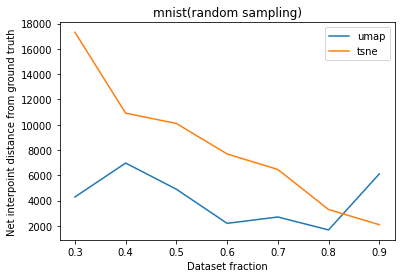

In [33]:
create_lineplots_by_dataset(data=distance_from_truth_results, dataset='mnist')

/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


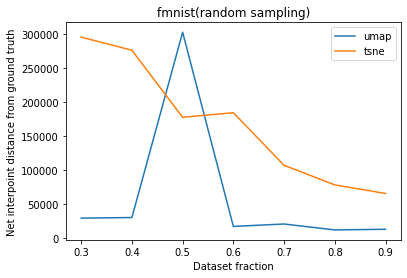

In [34]:
create_lineplots_by_dataset(data=distance_from_truth_results, dataset='fmnist')

/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


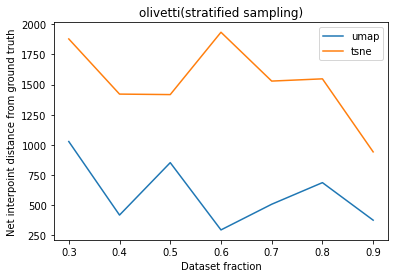

In [35]:
create_lineplots_by_dataset(data=distance_from_truth_results, dataset='olivetti', sampling='stratified')

/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


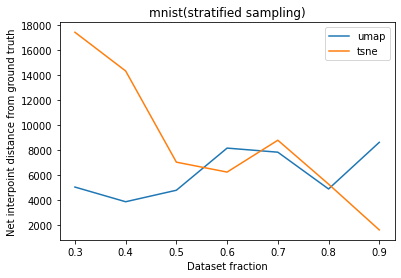

In [36]:
create_lineplots_by_dataset(data=distance_from_truth_results, dataset='mnist', sampling='stratified')

/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ketanjog/Desktop/Columbia_Classes/Year_3/Semester_5/unsupervised/project/DimConvergence/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


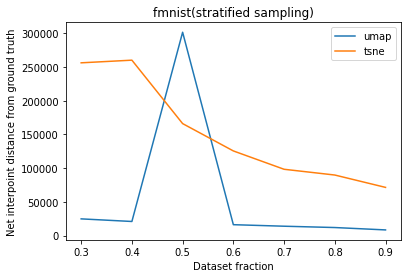

In [37]:
create_lineplots_by_dataset(data=distance_from_truth_results, dataset='fmnist', sampling='stratified')